In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

Load Pre-Filtered High-Quality VIIRS Data

In [2]:
df_viirs = pd.read_csv('../outputs/reports/high_quality_dates_for_analysis.csv')
df_viirs['date'] = pd.to_datetime(df_viirs['date'])

print(f"Loaded {len(df_viirs)} high-quality VIIRS observations")
print(f"Date range: {df_viirs['date'].min()} to {df_viirs['date'].max()}")
print(f"States: {df_viirs['state'].unique()}")
print(f"Observations per state:")
print(df_viirs['state'].value_counts())

Loaded 1586 high-quality VIIRS observations
Date range: 2021-03-01 00:00:00 to 2025-11-03 00:00:00
States: ['NJ' 'VT']
Observations per state:
state
NJ    800
VT    786
Name: count, dtype: int64


Select and Rename Features for ML

In [3]:
viirs_features = df_viirs[[
    'date',
    'state',
    'light_mean',
    'light_std',
    'lunar_irradiance_mean',
    'quality_score'
]].copy()

# Rename to match project terminology
viirs_features.rename(columns={
    'light_mean': 'gapfilled_ntl',
    'light_std': 'ntl_variability',
    'lunar_irradiance_mean': 'lunar_irradiance'
}, inplace=True)

print("Selected features:")
for col in viirs_features.columns:
    print(f"  - {col}")

print(f"\nVIIRS feature statistics:")
print(viirs_features.describe())

Selected features:
  - date
  - state
  - gapfilled_ntl
  - ntl_variability
  - lunar_irradiance
  - quality_score

VIIRS feature statistics:
                                date  gapfilled_ntl  ntl_variability  \
count                           1586    1586.000000      1586.000000   
mean   2023-11-16 19:48:29.962169344      24.417182         0.524792   
min              2021-03-01 00:00:00       0.000000         0.000000   
25%              2023-03-02 00:00:00       0.500000         0.000000   
50%              2023-11-09 12:00:00       0.611698         0.000000   
75%              2024-11-11 00:00:00      39.843235         0.073223   
max              2025-11-03 00:00:00     160.428977        65.690982   
std                              NaN      36.223069         2.845022   

       lunar_irradiance  quality_score  
count       1586.000000    1586.000000  
mean           4.389464       0.985001  
min            0.000000       0.853354  
25%            0.626202       0.983140  
50% 

Load BirdCast Data

In [16]:
df_nj = pd.read_csv('../data/birdcast/birdcast_peak_data_NJ.csv')
df_vt = pd.read_csv('../data/birdcast/birdcast_peak_data_VT.csv')

# Convert numeric columns to proper types
numeric_cols = ['total_passed', 'peak_birds', 'peak_altitude_ft', 'peak_speed_mph', 'peak_direction']

for col in numeric_cols:
    df_nj[col] = pd.to_numeric(df_nj[col], errors='coerce')
    df_vt[col] = pd.to_numeric(df_vt[col], errors='coerce')

df_nj['state'] = 'NJ'
df_vt['state'] = 'VT'
df_birds = pd.concat([df_nj, df_vt], ignore_index=True)
df_birds['date'] = pd.to_datetime(df_birds['date'])

print(f"Loaded {len(df_birds)} total BirdCast observations")
print(f"Date range: {df_birds['date'].min()} to {df_birds['date'].max()}")
print(f"Observations per state:")
print(df_birds['state'].value_counts())

print(f"\nBirdCast columns:")
for col in df_birds.columns:
    print(f"  - {col}")

print(f"\nMissing values in BirdCast:")
print(df_birds.isnull().sum())

print(f"\nRecords with zero migration: {(df_birds['total_passed'] == 0).sum()}")

Loaded 1690 total BirdCast observations
Date range: 2021-03-01 00:00:00 to 2025-11-04 00:00:00
Observations per state:
state
NJ    845
VT    845
Name: count, dtype: int64

BirdCast columns:
  - date
  - total_passed
  - peak_birds
  - peak_direction
  - peak_speed_mph
  - peak_altitude_ft
  - state

Missing values in BirdCast:
date                   0
total_passed          14
peak_birds            14
peak_direction      1690
peak_speed_mph       382
peak_altitude_ft     382
state                  0
dtype: int64

Records with zero migration: 2


Merge VIIRS and BirdCast on Date + State

In [17]:
df_merged = viirs_features.merge(
    df_birds,
    on=['date', 'state'],
    how='inner'
)

Merge Outputs

In [18]:
print(f"\n~~~~~ MERGE RESULTS ~~~~~")
print(f"VIIRS observations:     {len(viirs_features):,}")
print(f"BirdCast observations:  {len(df_birds):,}")
print(f"Merged observations:    {len(df_merged):,}")
print(f"Match rate:             {len(df_merged)/len(df_birds)*100:.1f}%")

print(f"\n~~~~~ MERGE VERIFICATION ~~~~~")
print(f"Unique dates in merged data: {df_merged['date'].nunique()}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")

print(f"\nRows per date (state coverage):")
date_state_counts = df_merged.groupby('date')['state'].count()
print(f"  Dates with both states (2 rows): {(date_state_counts == 2).sum()}")
print(f"  Dates with one state (1 row):    {(date_state_counts == 1).sum()}")

print(f"\nObservations per state after merge:")
print(df_merged['state'].value_counts())


~~~~~ MERGE RESULTS ~~~~~
VIIRS observations:     1,586
BirdCast observations:  1,690
Merged observations:    1,586
Match rate:             93.8%

~~~~~ MERGE VERIFICATION ~~~~~
Unique dates in merged data: 811
Date range: 2021-03-01 00:00:00 to 2025-11-03 00:00:00

Rows per date (state coverage):
  Dates with both states (2 rows): 775
  Dates with one state (1 row):    36

Observations per state after merge:
state
NJ    800
VT    786
Name: count, dtype: int64


Check for unmatched dates

In [19]:
viirs_dates = set(viirs_features['date'])
bird_dates = set(df_birds['date'])
merged_dates = set(df_merged['date'])

unmatched_viirs = viirs_dates - merged_dates
unmatched_birds = bird_dates - merged_dates

print(f"\n~~~~~ UNMATCHED DATES ~~~~~")
print(f"VIIRS dates not in merge: {len(unmatched_viirs)}")
print(f"BirdCast dates not in merge: {len(unmatched_birds)}")

if len(unmatched_viirs) > 0:
    print(f"\nSample unmatched VIIRS dates:")
    print(sorted(list(unmatched_viirs))[:5])
    
if len(unmatched_birds) > 0:
    print(f"\nSample unmatched BirdCast dates:")
    print(sorted(list(unmatched_birds))[:5])


~~~~~ UNMATCHED DATES ~~~~~
VIIRS dates not in merge: 0
BirdCast dates not in merge: 34

Sample unmatched BirdCast dates:
[Timestamp('2021-06-15 00:00:00'), Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-02 00:00:00'), Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-04 00:00:00')]


Add Temporal Features

In [20]:
df_merged['day_of_year'] = df_merged['date'].dt.dayofyear
df_merged['month'] = df_merged['date'].dt.month
df_merged['year'] = df_merged['date'].dt.year

# Season classification (migration periods)
def classify_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'other'

df_merged['season'] = df_merged['month'].apply(classify_season)

print("Added temporal features:")
print("  - day_of_year (1-365)")
print("  - month (1-12)")
print("  - year")
print("  - season (spring/fall/other)")

print(f"\nSeason distribution:")
print(df_merged['season'].value_counts())

print(f"\nYear distribution:")
print(df_merged['year'].value_counts().sort_index())

Added temporal features:
  - day_of_year (1-365)
  - month (1-12)
  - year
  - season (spring/fall/other)

Season distribution:
season
spring    705
fall      568
other     313
Name: count, dtype: int64

Year distribution:
year
2021    203
2022    191
2023    409
2024    393
2025    390
Name: count, dtype: int64


Final Dataset Summary

In [21]:
print(f"\n~~~~~ DIMENSIONS ~~~~~")
print(f"Total observations: {len(df_merged):,}")
print(f"Total features: {len(df_merged.columns)}")
print(f"Unique dates: {df_merged['date'].nunique()}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"Time span: {(df_merged['date'].max() - df_merged['date'].min()).days} days")

print(f"\n~~~~~ DATA QUALITY CHECK ~~~~~")
print(f"Missing values:")
missing = df_merged.isnull().sum()
if missing.sum() == 0:
    print("No missing values!")
else:
    print(missing[missing > 0])

print(f"\nDuplicate rows: {df_merged.duplicated().sum()}")


~~~~~ DIMENSIONS ~~~~~
Total observations: 1,586
Total features: 15
Unique dates: 811
Date range: 2021-03-01 00:00:00 to 2025-11-03 00:00:00
Time span: 1708 days

~~~~~ DATA QUALITY CHECK ~~~~~
Missing values:
peak_direction      1586
peak_speed_mph       347
peak_altitude_ft     347
dtype: int64

Duplicate rows: 0


Visualize Merged Dataset

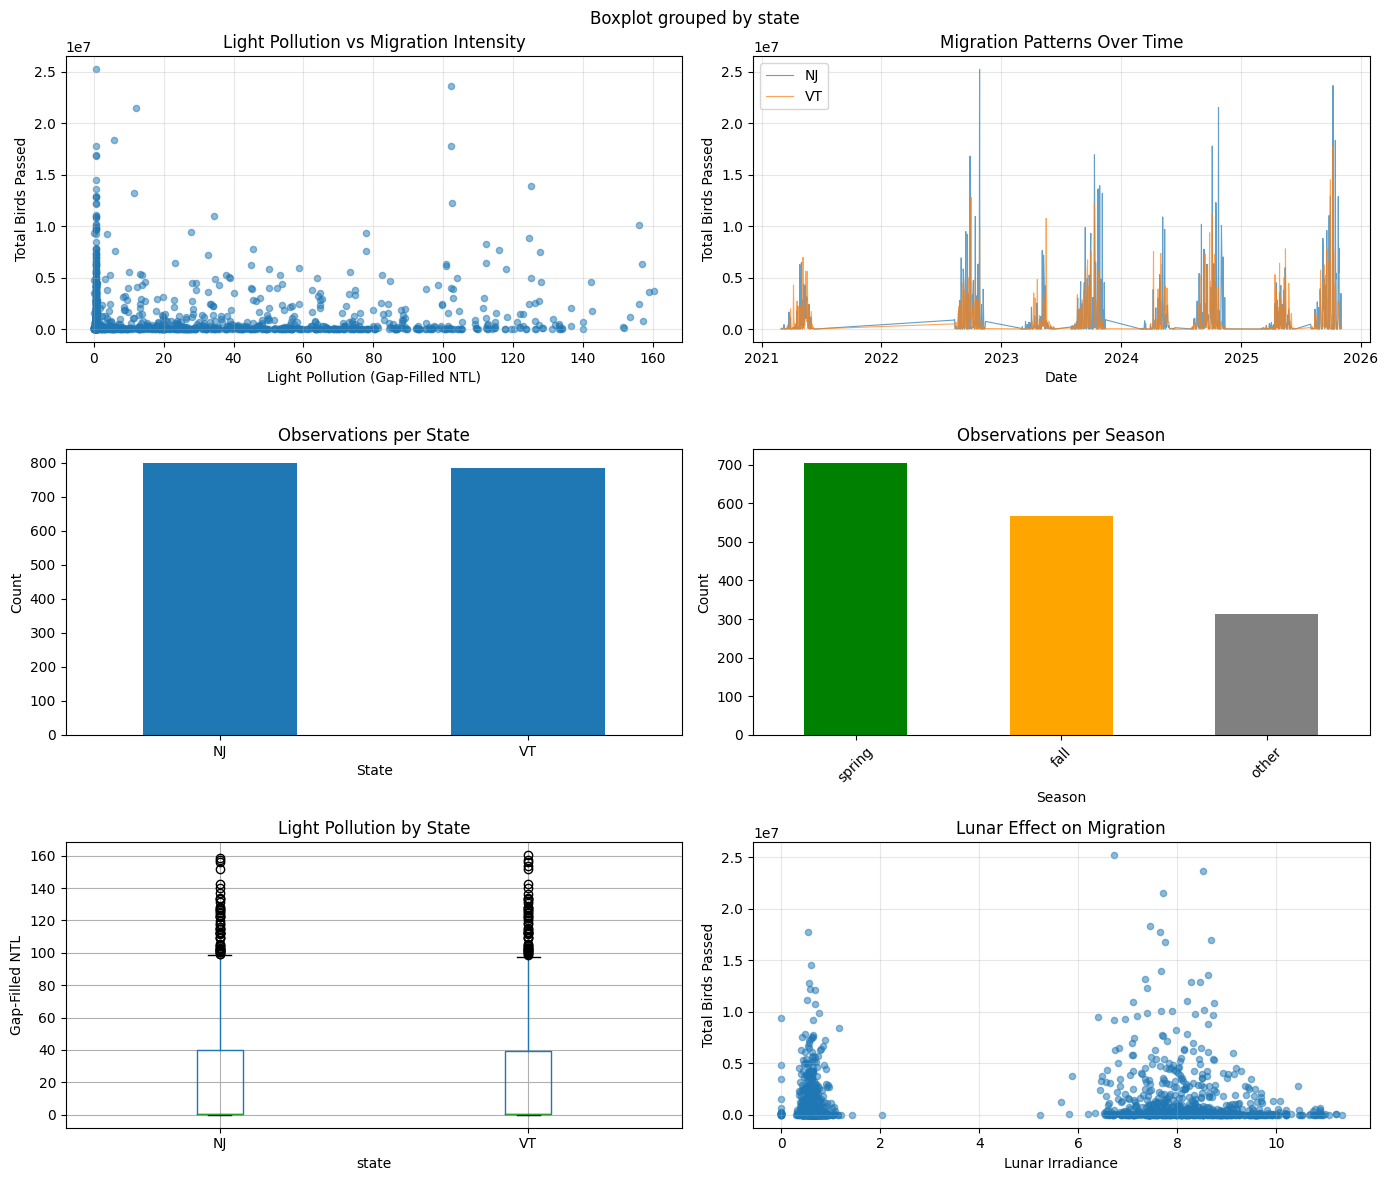

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. Light pollution vs migration intensity
axes[0,0].scatter(df_merged['gapfilled_ntl'], df_merged['total_passed'], 
                  alpha=0.5, s=20)
axes[0,0].set_xlabel('Light Pollution (Gap-Filled NTL)')
axes[0,0].set_ylabel('Total Birds Passed')
axes[0,0].set_title('Light Pollution vs Migration Intensity')
axes[0,0].grid(True, alpha=0.3)

# 2. Temporal pattern of migration
for state in ['NJ', 'VT']:
    state_data = df_merged[df_merged['state'] == state].sort_values('date')
    axes[0,1].plot(state_data['date'], state_data['total_passed'], 
                   label=state, alpha=0.7, linewidth=0.8)
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Total Birds Passed')
axes[0,1].set_title('Migration Patterns Over Time')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Data coverage by state
df_merged['state'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Observations per State')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xlabel('State')
plt.sca(axes[1,0])
plt.xticks(rotation=0)

# 4. Seasonal distribution
df_merged['season'].value_counts().plot(kind='bar', ax=axes[1,1], 
                                        color=['green', 'orange', 'gray'])
axes[1,1].set_title('Observations per Season')
axes[1,1].set_ylabel('Count')
axes[1,1].set_xlabel('Season')
plt.sca(axes[1,1])
plt.xticks(rotation=45)

# 5. Light pollution distribution by state
df_merged.boxplot(column='gapfilled_ntl', by='state', ax=axes[2,0])
axes[2,0].set_title('Light Pollution by State')
axes[2,0].set_ylabel('Gap-Filled NTL')
plt.sca(axes[2,0])
plt.xticks(rotation=0)

# 6. Lunar irradiance effect
axes[2,1].scatter(df_merged['lunar_irradiance'], df_merged['total_passed'],
                  alpha=0.5, s=20)
axes[2,1].set_xlabel('Lunar Irradiance')
axes[2,1].set_ylabel('Total Birds Passed')
axes[2,1].set_title('Lunar Effect on Migration')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/data_quality/merge_verification.png', 
            dpi=300, bbox_inches='tight')
plt.show()

[OPTIONAL] State Comparison

In [23]:
for state in ['NJ', 'VT']:
    state_data = df_merged[df_merged['state'] == state]
    print(f"\n~~~~~ {state} Statistics ~~~~~")
    print(f"Observations: {len(state_data)}")
    print(f"Light Pollution (mean): {state_data['gapfilled_ntl'].mean():.2f}")
    print(f"Migration Intensity (mean): {state_data['total_passed'].mean():.0f}")
    print(f"Migration Altitude (mean): {state_data['peak_altitude_ft'].mean():.0f} ft")
    print(f"Migration Speed (mean): {state_data['peak_speed_mph'].mean():.1f} mph")


~~~~~ NJ Statistics ~~~~~
Observations: 800
Light Pollution (mean): 24.44
Migration Intensity (mean): 1277166
Migration Altitude (mean): 1860 ft
Migration Speed (mean): 22.5 mph

~~~~~ VT Statistics ~~~~~
Observations: 786
Light Pollution (mean): 24.39
Migration Intensity (mean): 961891
Migration Altitude (mean): 1834 ft
Migration Speed (mean): 19.9 mph


Save Final Dataset

In [24]:
output_path = '../processed_data/final/merged_dataset.csv'
df_merged.to_csv(output_path, index=False)

print(f"Final dataset saved: {output_path}")
print(f"{len(df_merged):,} observations ready for ML modeling")
print(f"{len(df_merged.columns)} total features")

Final dataset saved: ../processed_data/final/merged_dataset.csv
1,586 observations ready for ML modeling
15 total features


Create data dictionary

In [25]:
data_dict = {
    'Feature': df_merged.columns,
    'Type': [df_merged[col].dtype for col in df_merged.columns],
    'Min': [df_merged[col].min() if pd.api.types.is_numeric_dtype(df_merged[col]) else 'N/A' 
            for col in df_merged.columns],
    'Max': [df_merged[col].max() if pd.api.types.is_numeric_dtype(df_merged[col]) else 'N/A' 
            for col in df_merged.columns],
    'Missing': [df_merged[col].isnull().sum() for col in df_merged.columns],
}

df_dict = pd.DataFrame(data_dict)
df_dict.to_csv('../outputs/reports/data_dictionary.csv', index=False)

print(df_dict.to_string(index=False))
print(f"\nData dictionary saved: ../outputs/reports/data_dictionary.csv")

         Feature           Type       Min         Max  Missing
            date datetime64[ns]       N/A         N/A        0
           state         object       N/A         N/A        0
   gapfilled_ntl        float64       0.0  160.428977        0
 ntl_variability        float64       0.0   65.690982        0
lunar_irradiance        float64       0.0   11.313858        0
   quality_score        float64  0.853354         1.0        0
    total_passed        float64       0.0  25221600.0        0
      peak_birds        float64     300.0  10023300.0        0
  peak_direction        float64       NaN         NaN     1586
  peak_speed_mph        float64       0.0        59.0      347
peak_altitude_ft        float64     500.0      5900.0      347
     day_of_year          int32        60         319        0
           month          int32         3          11        0
            year          int32      2021        2025        0
          season         object       N/A         N/A  